### Fern Ensemble Analysis.

Here we look at the most recent fern ensemble outputs with 'low_dim' i.e. UMAP n_components <= 40.

We also move to using Spectral Clustering for the concensus function, since HC tended to give very uneven clusters (hierarchical constraint not valid?)

In [3]:
import matplotlib.pyplot as plt
import pickle as pk
import pandas as pd
import numpy as np
import wandb
import umap
import seaborn as sns
import colorcet as cc
from itertools import combinations
import networkx as nx
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
from matplotlib.colors import ListedColormap
from sklearn.cluster import SpectralClustering

from utilities import run_configs, load_symptom_data, modularity, clustering_similarity

%matplotlib inline

In [4]:
LINKAGE_METHOD = 'average'
IGNORE_LABEL = None
SEED = 42

In [5]:
# with open('./fern_ensemble_outputs/both_CAS_20_0.5/ensemble_outputs.pickle', 'rb') as infile:
#     ensemble_outputs_cas = pk.load(infile)
# with open('./fern_ensemble_outputs/kmeans_CAS_20_0.5/ensemble_outputs.pickle', 'rb') as infile:
#     ensemble_outputs_cas = pk.load(infile)
    
# with open('./fern_ensemble_outputs/both_JC_20_0.5/ensemble_outputs.pickle', 'rb') as infile:
#     ensemble_outputs_cas = pk.load(infile)
    
# with open('./fern_ensemble_outputs/kmeans_JC_50_0.5/ensemble_outputs.pickle', 'rb') as infile:
#     ensemble_outputs_cas = pk.load(infile)
    
with open('./fern_ensemble_outputs_spectral/run_19_kmeans_JC_20_0.5/ensemble_outputs.pickle', 'rb') as infile:
    ensemble_outputs_cas = pk.load(infile)

In [6]:
# with open('./fern_ensemble_outputs/kmeans_JC_20_0.5/ensemble_outputs.pickle', 'rb') as infile:
#     ensemble_outputs = pk.load(infile)
    
# with open('./fern_ensemble_outputs/kmeans_JC_50_0.5/ensemble_outputs.pickle', 'rb') as infile:
#     ensemble_outputs = pk.load(infile)


# with open('./fern_ensemble_outputs/kmeans_JC_20_0.0/ensemble_outputs.pickle', 'rb') as infile:
#     ensemble_outputs = pk.load(infile)

# with open('./fern_ensemble_outputs/both_JC_20_0.5/ensemble_outputs.pickle', 'rb') as infile:
#     ensemble_outputs = pk.load(infile)
# with open('./fern_ensemble_outputs/hdbscan_CAS_20_0.5/ensemble_outputs.pickle', 'rb') as infile:
#     ensemble_outputs = pk.load(infile)
# with open('./fern_ensemble_outputs/kmeans_JC_20_0.5/ensemble_outputs.pickle', 'rb') as infile:
#     ensemble_outputs = pk.load(infile)

with open('./fern_ensemble_outputs_spectral/run_1_kmeans_JC_50_0.5/ensemble_outputs.pickle', 'rb') as infile:
    ensemble_outputs = pk.load(infile)

In [7]:
for i in range(15):
    nc = i + 1
    print(
        nc, 
        adjusted_mutual_info_score(
            ensemble_outputs[0]['final_clusters'][i], ensemble_outputs_cas[0]['final_clusters'][i]
        )
    )

1 1.0
2 0.8151506380463551
3 0.5015155973876537
4 0.5479040329992246
5 0.5598250325490842
6 0.6366855442465852
7 0.7391487547129576
8 0.6904338420952291
9 0.6982225177760256
10 0.6799267019830983
11 0.6624739689945494
12 0.662446791246078
13 0.6546009451178918
14 0.634843583054393
15 0.6264605142950479


In [8]:
all_data = pd.read_csv(run_configs[1]['data_path'], index_col=0)
all_data.loc[all_data.Physical_PEM_Severity==0, 'Physical_PEM_Severity'] = np.nan
all_data.loc[all_data.Cognitive_PEM_Severity==0, 'Cognitive_PEM_Severity'] = np.nan

In [9]:
symptom_data = load_symptom_data(run_configs[1]['data_path'])

In [10]:
def ensemble_to_co_association(ensemble):
    if isinstance(ensemble, pd.DataFrame) and 'labels' in ensemble.columns:
        df = pd.DataFrame(ensemble.labels)
        df = pd.DataFrame(df['labels'].to_list()).transpose()
    else:
        df = pd.DataFrame(ensemble).transpose()

    N = len(df)

    co_association_matrix = np.zeros([N, N])
    n_estimators = len(ensemble)

    for ri, row in df.iterrows():

        if ri%500 == 0:
            print(ri)

        compare = df.loc[ri + 1:]
        if IGNORE_LABEL is not None:
            shared_counts = ((row == compare) * (row != -1) * (compare != -1)).sum(axis=1)
        else:
            shared_counts = (row == compare).sum(axis=1)

        co_association_matrix[ri, ri + 1:] = shared_counts / n_estimators

    return co_association_matrix



In [11]:
# ensemble = ensemble_outputs[0]['library'].iloc[ensemble_outputs_cas[0]['ensemble_indices']]

In [12]:
# final_co_association_matrix = ensemble_to_co_association(ensemble)

In [13]:
# sc = SpectralClustering(6, affinity='precomputed', n_init=100)
# sc.fit(final_co_association_matrix)        

In [11]:
def convert_age(age_string):
    conversion_diict = {
        '30-39': 35,
        '40-49': 45,
        '50-59': 55,
        '18-29': 24,
        '60-69': 65,
        '70-79': 75,
        '80+': 85
    }
    return conversion_diict[age_string]


def build_cluster_summary(data, labels):

    _all_data= data.copy()
    symptoms = [
        col
        for col in _all_data.columns
        if 'Symptom' in col
    ]

    _all_data['cluster'] = labels
    _all_data['dummy'] = 1
    _all_data['woman'] = _all_data['Demographics_Gender_Cleaned'] == 'Woman'
    _all_data['Flag_MCAS_norm'] = _all_data['Flag_MCAS'] / 6
    _all_data['symptom_count'] = _all_data[symptoms].sum(axis=1)
    _all_data['age_numeric'] = _all_data['Demographics_Age_Cleaned'].apply(convert_age)
    _all_data['Physical_PEM_Severity_norm'] = _all_data['Physical_PEM_Severity'] / 10
    _all_data['Cognitive_PEM_Severity_norm'] = _all_data['Cognitive_PEM_Severity'] / 10

    cluster_summary = _all_data.groupby('cluster').agg({
        'dummy': len,
        'Flag_MECFS': sum,
        'Flag_POTS': pd.Series.mode,
        'Flag_MCAS_norm': sum,
        'woman': sum,
        'symptom_count': np.median,
        'age_numeric': np.mean,
        'Physical_PEM_Severity_norm': np.nanmean,
        'Cognitive_PEM_Severity_norm': np.nanmean
    })
    cluster_summary['Flag_MECFS'] /= cluster_summary['dummy']
    cluster_summary['Flag_MCAS_norm'] /= cluster_summary['dummy']
    cluster_summary['woman'] /= cluster_summary['dummy']
    cluster_summary.rename(columns={'dummy': 'size'}, inplace=True)

    return cluster_summary

In [12]:
# final_clusters = sc.labels_
# final_clusters = ensemble_outputs_cas[1]['final_clusters'][7]
# final_clusters = ensemble_outputs[0]['final_clusters'][5]
# final_clusters = pd.read_csv('../clusterings/chris/parametric_umap_n_clusters_7.csv', index_col=0)


#final_clusters = pd.read_csv('../clusterings/chris/umap_kmeans_ensemble_up_to_40_components_inclusion_any_n_cluster_8.csv', index_col=0)
final_clusters = pd.read_csv('../clusterings/chris/lowdim_spectral_ensemble_50_kmeans_joint_criterion_alpha_0.5_n_clusters_8.csv', index_col=0)

In [13]:
vals = np.unique(final_clusters, return_counts=True)
vals

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([ 615,  872,  506, 1105,  887,  727,  611,  708]))

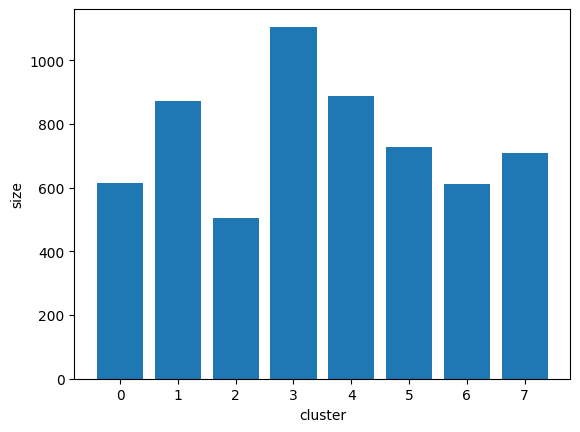

In [14]:
plt.bar(vals[0], vals[1])
plt.xlabel('cluster')
plt.ylabel('size');

In [15]:
# final_clusters

In [16]:
fc = pd.DataFrame(index=symptom_data.index)
fc['cluster'] = final_clusters

In [17]:
# fc.to_csv('../clusterings/chris/lowdim_spectral_ensemble_50_kmeans_joint_criterion_alpha_0.5_n_clusters_6.csv')

In [19]:
build_cluster_summary(all_data, final_clusters)

,size,Flag_MECFS,Flag_POTS,Flag_MCAS_norm,woman,symptom_count,age_numeric,Physical_PEM_Severity_norm,Cognitive_PEM_Severity_norm
cluster,,,,,,,,,
0,615,0.596748,"Possible, had tachycardia/palpitations",0.130081,0.832520,53.0,45.087805,0.806937,0.738581
1,872,0.308486,"No, no tachycardia",0.101491,0.747706,30.0,47.665138,0.740079,0.478479
2,506,0.361660,"Possible, had tachycardia/palpitations",0.365613,0.865613,89.0,45.535573,0.875547,0.785714
3,1105,0.578281,"No, no tachycardia",0.091101,0.693213,34.0,47.314027,0.748592,0.654334
4,887,0.178129,"No, no tachycardia",0.068207,0.692221,21.0,50.337091,0.675869,0.478670
5,727,0.650619,"Possible, had tachycardia/palpitations",0.154287,0.833563,54.0,45.005502,0.793506,0.610575
6,611,0.553191,"Possible, had tachycardia/palpitations",0.229405,0.855974,69.0,45.664484,0.848414,0.736286
7,708,0.548023,"No, no tachycardia",0.095574,0.836158,40.0,47.194915,0.762693,0.554049


In [20]:
baseline_frequencies = {
    col: all_data[col].sum() / len(all_data)
    for col in all_data.columns
    if 'Symptom' in col
}

In [62]:
baseline_df = pd.DataFrame(index=baseline_frequencies.keys())
baseline_df['population'] = baseline_frequencies.values()
baseline_df.sort_values('population', ascending=False, inplace=True)

In [63]:
baseline_df

,population
Symptom_Fatigue,0.979440
Symptom_Memory_short,0.924225
Symptom_PEM,0.883601
Symptom_Cognitive_Functioning_attentionconcentration,0.752943
Symptom_Shortness_of_breath,0.736860
...,...
Symptom_SkinAllergy_shingles,0.025701
Symptom_Hallucinations_other,0.023379
Symptom_Reproductive_postmenopausal_bleeding,0.016084
Symptom_Reproductive_early_menopause,0.013928


In [91]:
def build_cluster_symptoms(data, labels, baseline_df):

    _all_data= data.copy()
#     symptoms = [
#         col
#         for col in _all_data.columns
#         if 'Symptom' in col
#     ]
    symptoms= list(baseline_df.index)
    _all_data['cluster'] = labels
    count = _all_data.groupby('cluster').sum()[symptoms]
    size = _all_data.groupby('cluster').agg({'Symptom_Memory_short': 'count'}).rename(columns={'Symptom_Memory_short': 'size'})
    
    for col in count.columns:
        count[col] = count[col] / size['size']

    delta = count.copy().transpose()
    for col in delta.columns:
        delta[col] -= baseline_df.population
        
    cluster_symptoms = {}
    more_common_symptoms = {}
    less_common_symptoms = {}
    full_symptoms_by_cluster = baseline_df.copy()
    
    for c in np.unique(labels):
        cluster_symptoms[c] = pd.DataFrame({
            'diff': delta[c],
            'abs': count.transpose()[c]
        })#.sort_values('diff', ascending=False)
        cluster_symptoms[c]['diff (abs)'] = [
            ('%.3f (%.3f)' % (row['diff'], row['abs'])) for i, row in cluster_symptoms[c].iterrows()
        ]
        
#         full_symptoms_by_cluster[c] = [
#             ('%.3f (%.3f)' % (row['diff'], row['abs'])) for i, row in cluster_symptoms[c].iterrows()
#         ]
        full_symptoms_by_cluster['%d delta' % c] = [
            ('%.3f' % row['diff']) for i, row in cluster_symptoms[c].iterrows()
        ]
        full_symptoms_by_cluster['%d freq' % c] = [
            ('%.3f' % row['abs']) for i, row in cluster_symptoms[c].iterrows()
        ]
        
        more_common_symptoms[c] = cluster_symptoms[c][cluster_symptoms[c]['diff'] > 0].iloc[0:10]
        less_common_symptoms[c] = cluster_symptoms[c][cluster_symptoms[c]['diff'] < 0].iloc[-10:]
        
    return cluster_symptoms, more_common_symptoms, less_common_symptoms, full_symptoms_by_cluster

In [92]:
cluster_symptoms, more_common_symptoms, less_common_symptoms, full_symptoms_by_cluster  = build_cluster_symptoms(all_data, final_clusters, baseline_df)
# cluster_symptoms = build_cluster_symptoms(all_data, list(tessa.cluster), baseline_df)

In [93]:
symptom_names = [i.replace('Symptom_', '') for i in full_symptoms_by_cluster.index]

In [94]:
full_symptoms_by_cluster.population = full_symptoms_by_cluster.population.round(3)
full_symptoms_by_cluster.set_index(keys=pd.Index(symptom_names), inplace=True)

In [95]:
full_symptoms_by_cluster.to_csv('../clusterings/chris/full_symptom_table.csv')

In [96]:
full_symptoms_by_cluster

,population,0 delta,0 freq,1 delta,1 freq,2 delta,2 freq,3 delta,3 freq,4 delta,4 freq,5 delta,5 freq,6 delta,6 freq,7 delta,7 freq
Fatigue,0.979,0.021,1.000,-0.012,0.968,0.017,0.996,0.018,0.997,-0.070,0.910,0.014,0.993,0.016,0.995,0.016,0.996
Memory_short,0.924,0.035,0.959,0.005,0.929,0.044,0.968,-0.021,0.903,-0.028,0.896,-0.001,0.923,0.038,0.962,-0.032,0.893
PEM,0.884,0.084,0.967,-0.005,0.878,0.110,0.994,0.030,0.914,-0.308,0.576,0.074,0.957,0.097,0.980,0.033,0.917
Cognitive_Functioning_attentionconcentration,0.753,0.216,0.969,-0.365,0.388,0.229,0.982,0.167,0.920,-0.356,0.397,0.125,0.878,0.191,0.944,-0.010,0.743
Shortness_of_breath,0.737,0.105,0.842,0.088,0.825,0.192,0.929,-0.114,0.623,-0.436,0.301,0.134,0.871,0.167,0.903,0.106,0.843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SkinAllergy_shingles,0.026,-0.001,0.024,-0.006,0.019,0.051,0.077,-0.010,0.015,-0.012,0.014,0.010,0.036,-0.001,0.025,-0.006,0.020
Hallucinations_other,0.023,-0.004,0.020,-0.013,0.010,0.036,0.059,-0.008,0.015,-0.009,0.015,0.003,0.026,0.016,0.039,0.001,0.024
Reproductive_postmenopausal_bleeding,0.016,-0.005,0.011,-0.001,0.015,0.019,0.036,-0.005,0.011,-0.010,0.006,-0.002,0.014,0.010,0.026,0.007,0.023
Reproductive_early_menopause,0.014,0.006,0.020,-0.009,0.005,0.018,0.032,-0.006,0.008,-0.003,0.011,0.003,0.017,0.006,0.020,-0.001,0.013


In [69]:
for c in np.unique(final_clusters):
    print(
        c, 
        [s.replace('Symptom_', '') for s in list(more_common_symptoms[c].index)]
    )

0 ['Fatigue', 'Memory_short', 'PEM', 'Cognitive_Functioning_attentionconcentration', 'Shortness_of_breath', 'Insomnia', 'Tightness_of_chest', 'Muscle_aches', 'Dizziness_vertigo', 'Cognitive_Functioning_thinking']
1 ['Memory_short', 'Shortness_of_breath', 'Tightness_of_chest', 'Heart_palpitations', 'Gasping_air_normal_oxygen', 'Pain_burning_chest', 'Respiratory_other']
2 ['Fatigue', 'Memory_short', 'PEM', 'Cognitive_Functioning_attentionconcentration', 'Shortness_of_breath', 'Insomnia', 'Tightness_of_chest', 'Muscle_aches', 'Dizziness_vertigo', 'Cognitive_Functioning_thinking']
3 ['Fatigue', 'PEM', 'Cognitive_Functioning_attentionconcentration', 'Cognitive_Functioning_thinking', 'Cognitive_Functioning_executive', 'Cognitive_Functioning_problemsolving', 'Speech_difficulty_finding_words', 'Cognitive_Functioning_slowedthoughts', 'Memory_long', 'Speech_difficulty_communicating_verbally']
4 ['Loss_of_smell', 'Loss_of_taste', 'Altered_smell', 'Respiratory_other']
5 ['Fatigue', 'PEM', 'Cogniti

In [770]:
for c in np.unique(final_clusters):
    print(c, list(less_common_symptoms[c].index))

0 []
1 ['Symptom_Speech_difficulty_reading_processing_text', 'Symptom_Speech_difficulty_communicating_verbally', 'Symptom_Speech_difficulty_understanding_others_speech', 'Symptom_Speech_difficulty_finding_words', 'Symptom_Cognitive_Functioning_slowedthoughts', 'Symptom_Memory_long', 'Symptom_Cognitive_Functioning_attentionconcentration', 'Symptom_Cognitive_Functioning_problemsolving', 'Symptom_Cognitive_Functioning_executive', 'Symptom_Cognitive_Functioning_thinking']
2 ['Symptom_Eye_Vision_dry_eyes', 'Symptom_SkinAllergy_itchy_eyes', 'Symptom_Ear_numbness', 'Symptom_Neuralgia', 'Symptom_Bulging_veins', 'Symptom_Sensations_numbness_loss_sensation', 'Symptom_Petechiae', 'Symptom_SkinAllergy_brittle_nail', 'Symptom_Ear_ear_pain', 'Symptom_Ear_changes_to_ear_canal']
3 ['Symptom_Cognitive_Functioning_attentionconcentration', 'Symptom_Tachycardia', 'Symptom_Heart_palpitations', 'Symptom_Pain_burning_chest', 'Symptom_Shortness_of_breath', 'Symptom_Gasping_air_normal_oxygen', 'Symptom_Tightne

In [28]:
symptom_data

,Symptom_Memory_short,Symptom_Memory_long,Symptom_Memory_no_new_memories,Symptom_Memory_forget_tasks,Symptom_Memory_other,Symptom_Cognitive_Functioning_thinking,Symptom_Cognitive_Functioning_executive,Symptom_Cognitive_Functioning_problemsolving,Symptom_Cognitive_Functioning_slowedthoughts,Symptom_Cognitive_Functioning_fastthoughts,...,Symptom_SkinAllergy_itchy_skin,Symptom_SkinAllergy_itchy_eyes,Symptom_SkinAllergy_heighted_reaction_allergies,Symptom_SkinAllergy_brittle_nail,Symptom_SkinAllergy_other_itchy,Symptom_SkinAllergy_shingles,Symptom_PEM,Symptom_Fatigue,Symptom_Change_sensitivity_to_meds,Symptom_New_allergies
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,1,1,0,1
5,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0,0,0,1,0,0,1,1,0,0
6,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,1,1,0,0
8,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,1,1,0,0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14158,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,1,1,0,1,0,0,1,1,1,0
14161,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,1,0,0,0,0,0,1,1,0,0
14163,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0,0,0,0,0,0,1,1,1,0
14166,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [283]:
ensemble_outputs[0].keys()

dict_keys(['seed', 'library_clusters', 'final_clusters', 'library', 'ensemble_indices', 'ari_with_base_final', 'ami_with_base_final', 'ari_with_base_library', 'ami_with_base_library', 'ari_with_tessa', 'ami_with_tessa'])

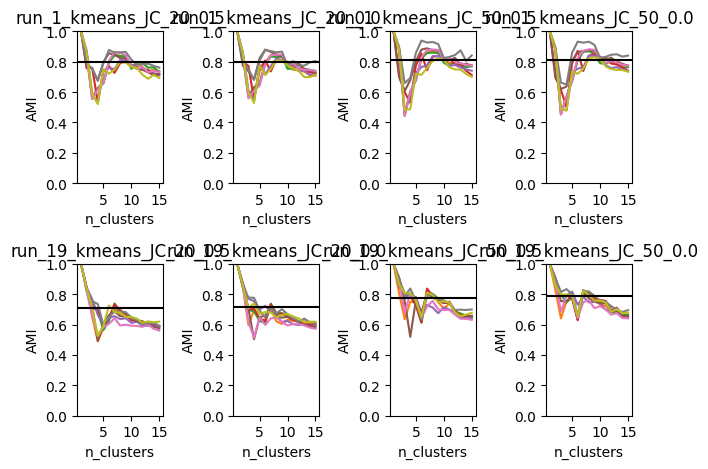

In [80]:
# E = ['kmeans_JC_50_0.5', 'kmeans_CAS_50_0.5', 'kmeans_JC_20_0.5', 'kmeans_CAS_20_0.5', 
#      'kmeans_CAS_100_0.5', 'kmeans_JC_20_0.0', 'kmeans_JC_100_0.5', 'kmeans_JC_100_0.0']

# E = ['kmeans_JC_50_0.5', 'hdbscan_JC_20_0.5', 'kmeans_JC_20_0.5', 'kmeans_CAS_20_0.5', 'hdbscan_CAS_20_0.5', 'kmeans_JC_20_0.0']

E = [
    'run_1_kmeans_JC_20_0.5', 'run_1_kmeans_JC_20_0.0', 
    'run_1_kmeans_JC_50_0.5', 'run_1_kmeans_JC_50_0.0',
    'run_19_kmeans_JC_20_0.5', 'run_19_kmeans_JC_20_0.0', 
    'run_19_kmeans_JC_50_0.5', 'run_19_kmeans_JC_50_0.0'
]

for ei, e in enumerate(E):
    with open('./fern_ensemble_outputs_spectral/%s/ensemble_outputs.pickle' % e, 'rb') as infile:
#     with open('./fern_ensemble_outputs/%s/ensemble_outputs.pickle' % e, 'rb') as infile:
        _ensemble_outputs = pk.load(infile)

    plt.subplot(2,4,ei+1)
    plt.title(e)
    
    M=[]
    for i in range(10):
        if len(_ensemble_outputs) > i+1:
            plt.plot(
                [i+1 for i in range(15)],
                _ensemble_outputs[i]['ami_with_base_final']
            )
            M.append(_ensemble_outputs[i]['ami_with_base_final'])
        
    plt.axhline(np.mean(M), c='k')
    plt.xlabel('n_clusters')
    plt.ylabel('AMI')
    plt.ylim([0,1])
        
plt.tight_layout()

In [81]:
# # E = ['kmeans_JC_50_0.5', 'kmeans_CAS_50_0.5', 'kmeans_JC_20_0.5', 'kmeans_CAS_20_0.5', 'kmeans_CAS_100_0.5', 'kmeans_JC_20_0.0']

# E = ['kmeans_JC_50_0.5', 'kmeans_CAS_50_0.5', 'kmeans_JC_20_0.5', 'kmeans_CAS_20_0.5', 
#      'kmeans_CAS_100_0.5', 'kmeans_JC_20_0.0', 'kmeans_JC_100_0.5', 'kmeans_JC_100_0.0']


# for ei, e in enumerate(E):
#     with open('./fern_ensemble_outputs/%s/ensemble_outputs.pickle' % e, 'rb') as infile:
#         _ensemble_outputs = pk.load(infile)

#     plt.subplot(2,4,ei+1)
#     plt.title(e)
#     M=[]
#     for i in range(10):
#         if len(_ensemble_outputs) > i+1:
#             plt.plot(
#                 [i+1 for i in range(15)],
#                 _ensemble_outputs[i]['ari_with_base_final']
#             )
#             M.append(_ensemble_outputs[i]['ari_with_base_final'])
        
#     plt.axhline(np.mean(M), c='k')
#     plt.xlabel('n_clusters')
#     plt.ylabel('ARI')
#     plt.ylim([0,1])
        
# plt.tight_layout()

In [298]:
# E = ['both_JC_20_0.5', 'both_CAS_20_0.5', 'kmeans_JC_20_0.5', 'kmeans_CAS_20_0.5', 'hdbscan_JC_20_0.5', 'hdbscan_CAS_20_0.5']

# for ei, e in enumerate(E):
#     with open('./fern_ensemble_outputs/%s/ensemble_outputs.pickle' % e, 'rb') as infile:
#         _ensemble_outputs = pk.load(infile)

#     plt.subplot(2,3,ei+1)
#     plt.title(e)
#     for i in range(10):
#         plt.plot(
#             [i+1 for i in range(15)],
#             _ensemble_outputs[i]['ami_with_tessa']
#         )
#         plt.axvline(6, c='k')
#         plt.xlabel('n_clusters')
#         plt.ylabel('AMI_Tessa')
#         plt.ylim([0,1])
        
# plt.tight_layout()

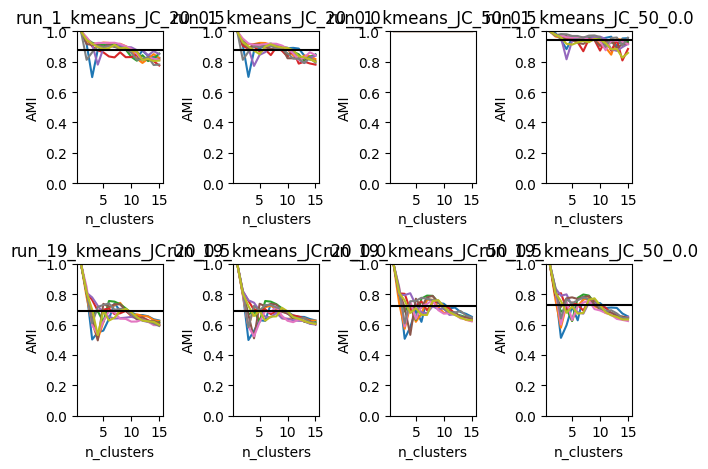

In [83]:
base_E = 'run_1_kmeans_JC_50_0.5'

E = [
    'run_1_kmeans_JC_20_0.5', 'run_1_kmeans_JC_20_0.0', 
    'run_1_kmeans_JC_50_0.5', 'run_1_kmeans_JC_50_0.0',
    'run_19_kmeans_JC_20_0.5', 'run_19_kmeans_JC_20_0.0', 
    'run_19_kmeans_JC_50_0.5', 'run_19_kmeans_JC_50_0.0'
]

with open('./fern_ensemble_outputs_spectral/%s/ensemble_outputs.pickle' % base_E, 'rb') as infile:
        _base_e = pk.load(infile)

for ei, e in enumerate(E):
    with open('./fern_ensemble_outputs_spectral/%s/ensemble_outputs.pickle' % e, 'rb') as infile:
        _ensemble_outputs = pk.load(infile)

    plt.subplot(2,4,ei+1)
    plt.title(e)
    M=[]
    for i in range(len(_base_e)):
#     for i in range(10):
        if len(_ensemble_outputs) > i+1:
            ami = [
                adjusted_mutual_info_score(
                    _base_e[i]['final_clusters'][j],
                    _ensemble_outputs[i]['final_clusters'][j]
                )
                for j in range(15)
            ]

            plt.plot(
                [i+1 for i in range(15)],
                ami
            )
            M.append(ami)
        
    plt.axhline(np.mean(M), c='k')
    plt.xlabel('n_clusters')
    plt.ylabel('AMI')
    plt.ylim([0,1])
        
plt.tight_layout()

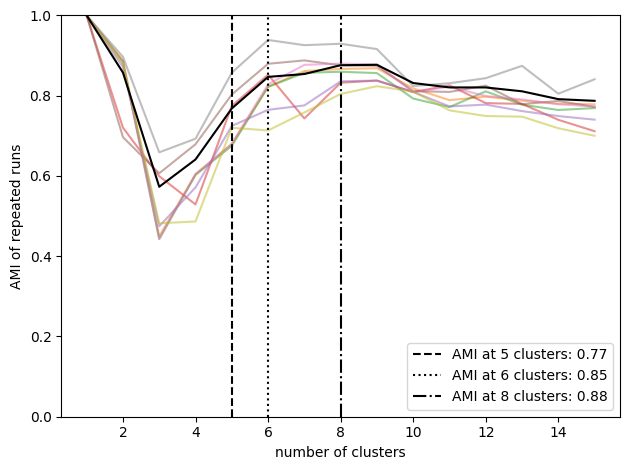

In [45]:
base_E = 'run_1_kmeans_JC_50_0.5'

E = [
    'run_1_kmeans_JC_50_0.5'
]

with open('./fern_ensemble_outputs_spectral/%s/ensemble_outputs.pickle' % base_E, 'rb') as infile:
        _base_e = pk.load(infile)

for ei, e in enumerate(E):
    with open('./fern_ensemble_outputs_spectral/%s/ensemble_outputs.pickle' % e, 'rb') as infile:
        _ensemble_outputs = pk.load(infile)

    plt.subplot(1,1,ei+1)
#     plt.title(e)
    M=[]
    for i in range(len(_base_e)):
#     for i in range(10):
        if len(_ensemble_outputs) > i+1:
            ami = [
                adjusted_mutual_info_score(
                    _base_e[0]['final_clusters'][j],
                    _ensemble_outputs[i]['final_clusters'][j]
                )
                for j in range(15)
            ]

            plt.plot(
                [i+1 for i in range(15)],
                ami,
                alpha=0.5
            )
            M.append(ami)
        
#     plt.axhline(np.mean(M), c='k')
    plt.plot([i+1 for i in range(15)], np.array(M).mean(axis=0), c='k')
    plt.xlabel('number of clusters')
    plt.ylabel('AMI of repeated runs')
    plt.ylim([0,1])
    plt.axvline(5, linestyle='--', c='k', label='AMI at 5 clusters: %.2f' % np.array(M).mean(axis=0)[4])
    plt.axvline(6, linestyle=':', c='k', label='AMI at 6 clusters: %.2f' % np.array(M).mean(axis=0)[5])
    plt.axvline(8, linestyle='-.', c='k', label='AMI at 8 clusters: %.2f' % np.array(M).mean(axis=0)[7])
#     plt.axhline(np.array(M).mean(axis=0)[7], linestyle='--', c='k')
        
plt.legend()
plt.tight_layout()

In [82]:
# base_E = 'kmeans_JC_100_0.5'
# # base_E = 'both_JC_20_0.5'
# # E = ['kmeans_JC_50_0.5', 'kmeans_CAS_50_0.5', 'kmeans_JC_20_0.5', 'kmeans_CAS_20_0.5', 'kmeans_CAS_100_0.5', 'kmeans_JC_20_0.0']

# E = ['kmeans_JC_50_0.5', 'kmeans_CAS_50_0.5', 'kmeans_JC_20_0.5', 'kmeans_CAS_20_0.5', 
#      'kmeans_CAS_100_0.5', 'kmeans_JC_20_0.0', 'kmeans_JC_100_0.5', 'kmeans_JC_100_0.0']


# with open('./fern_ensemble_outputs/%s/ensemble_outputs.pickle' % base_E, 'rb') as infile:
#         _base_e = pk.load(infile)

# for ei, e in enumerate(E):
#     with open('./fern_ensemble_outputs/%s/ensemble_outputs.pickle' % e, 'rb') as infile:
#         _ensemble_outputs = pk.load(infile)

#     plt.subplot(2,4,ei+1)
#     plt.title(e)
#     M=[]
#     for i in range(len(_base_e)):
# #     for i in range(10):
#         if len(_ensemble_outputs) > i+1:
#             ami = [
#                 adjusted_mutual_info_score(
#                     _base_e[i]['final_clusters'][j],
#                     _ensemble_outputs[i]['final_clusters'][j]
#                 )
#                 for j in range(15)
#             ]

#             plt.plot(
#                 [i+1 for i in range(15)],
#                 ami
#             )
#             M.append(ami)
        
#     plt.axhline(np.mean(M), c='k')
#     plt.xlabel('n_clusters')
#     plt.ylabel('AMI')
#     plt.ylim([0,1])
        
# plt.tight_layout()

#### We need to add a function for computing partial similarity when only a subset of patients are used....